# Set dirs for kaggle

In [1]:
import os
from pathlib import Path
import shutil
import sys

input_dir = Path('/kaggle/input')
project_dirs = []

for item in input_dir.iterdir():
    if item.is_dir():
        sasrec_path = item / 'sasrec'
        if sasrec_path.exists() and sasrec_path.is_dir():
            project_dirs.append(item)

if project_dirs:
    source_dir = project_dirs[0]
    
    working_dir = Path('/kaggle/working')
    for item in source_dir.iterdir():
        dest = working_dir / item.name
        if item.is_dir():
            if dest.exists():
                shutil.rmtree(dest)
            shutil.copytree(item, dest)
        else:
            shutil.copy2(item, dest)
else:
    print("Not found")


sys.path.insert(0, '/kaggle/working')
sys.path.insert(0, '/kaggle/working/sasrec')
sys.path.insert(0, '/kaggle/working/sasrec/src')

# Imports

In [2]:
import logging
import torch
from torch.nn import init
from torch import optim
import pandas as pd

from src.dataset import Dataset
from src.model import (
    SASRec,
    QuantSASRecLSQ,
    QuantSASRecPACT,
    QuantSASRecAdaRound,
    QuantSASRecAPoT,
    QuantSASRecDoReFa,
    QuantSASRecSTE,
)
from src.trainer import Trainer

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


# Configs

In [3]:
import torch

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset parameters
DATA_FILEPATH = "data/movie-lens_1m.txt"
BATCH_SIZE = 128
MAX_SEQ_LEN = 50

# Model architecture
HIDDEN_DIM = 50
NUM_BLOCKS = 2
DROPOUT = 0.5
SHARE_ITEM_EMB = False

# Training parameters
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 0.0
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8

# Scheduler (optional)
USE_SCHEDULER = False
SCHEDULER_TYPE = "onecycle"
WARMUP_RATIO = 0.05

# Evaluation
EVALUATE_K = 10
EARLY_STOP_EPOCH = 10

# Quantization parameters
BITS = 8  # INT8 quantization
PACT_INIT_ALPHA = 6.0
APOT_K = 1
APOT_INIT_ALPHA_ACT = 6.0
APOT_USE_WEIGHT_NORM = False
DOREFA_ACT_SIGNED = True
DOREFA_ACT_PREPROC = "tanh"

# Paths
OUTPUT_DIR = "outputs"
LOG_DIR = "logs"

# Other
RANDOM_SEED = 42
DEBUG = False

print(f"Using device: {device}")

Using device: cuda


# Data Read

In [4]:
data_filepath = '/kaggle/working/sasrec/data/movie-lens_1m.txt'
dataset = Dataset(
    batch_size=BATCH_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    data_filepath=data_filepath,
    debug=False,
)

num_items = dataset.num_items
print(f"Dataset: {dataset.num_users} users, {dataset.num_items} items")

Getting train/valid/test splits: 100%|██████████| 6040/6040 [00:00<00:00, 74750.44it/s]

Dataset: 6040 users, 3416 items


# Train 

In [5]:
def train_model(model, dataset, device, epochs=EPOCHS, lr=LR, model_name="model"):
    print("=" * 80)
    print(f"Training: {model_name}")
    print("=" * 80)
    
    for param in model.parameters():
        try:
            init.xavier_uniform_(param.data)
        except ValueError:
            continue
    
    model = model.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    
    save_dir = f'/kaggle/working/outputs/{model_name}'
    os.makedirs(save_dir, exist_ok=True)
    
    trainer = Trainer(
        dataset=dataset, model=model, optimizer=optimizer, evaluate_k=EVALUATE_K,
        max_lr=lr, num_epochs=epochs, early_stop_epoch=EARLY_STOP_EPOCH,
        warmup_ratio=0.05, use_scheduler=False, scheduler_type="onecycle",
        save_dir=save_dir, resume_training=False, device=str(device),
    )
    
    best_results = trainer.train()
    best_ndcg_epoch, best_model_state_dict, _ = best_results
    
    model.load_state_dict(best_model_state_dict)
    test_ndcg, test_hit_rate = trainer.evaluate(mode="test", model=model)
    
    print(f"\\nTest: nDCG@{EVALUATE_K}={test_ndcg:.6f}, Hit@{EVALUATE_K}={test_hit_rate:.6f}")
    
    return {
        'model_name': model_name,
        'test_ndcg': test_ndcg,
        'test_hit': test_hit_rate,
        'best_epoch': best_ndcg_epoch
    }

In [6]:
all_results = []

In [7]:
model_base = SASRec(
    num_items=num_items,
    num_blocks=NUM_BLOCKS,
    hidden_dim=HIDDEN_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout_p=DROPOUT,
    share_item_emb=SHARE_ITEM_EMB,
    device=str(device),
)
all_results.append(train_model(model_base, dataset, device, model_name="sasrec_base"))

Training: sasrec_base


Training: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 57.65it/s]
2025-11-17 13:24:45,548 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_base
2025-11-17 13:24:45,562 | INFO | root | 
	Epoch 0:
		Training Loss:  83.771774, 
		nDCG@10:  0.2273, 
		Hit@10:   0.4116
Training: 100%|██████████| 48/48 [00:12<00:00,  3.73it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 66.43it/s]
2025-11-17 13:24:59,197 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_base
2025-11-17 13:24:59,208 | INFO | root | 
	Epoch 1:
		Training Loss:  63.692720, 
		nDCG@10:  0.2307, 
		Hit@10:   0.4225
Training: 100%|██████████| 48/48 [00:13<00:00,  3.66it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 62.39it/s]
2025-11-17 13:25:13,100 | INFO | root | 
	Epoch 2:
		Training Loss:  58.925639, 
		nDCG@10:  0.2239, 
		Hit@10:   0.4103
Training: 100%|██████████| 48/48 [00:12<00:00,  3.70

\nTest: nDCG@10=0.365687, Hit@10=0.623179


In [8]:
model_lsq = QuantSASRecLSQ(
    num_items=num_items,
    num_blocks=NUM_BLOCKS,
    hidden_dim=HIDDEN_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout_p=DROPOUT,
    share_item_emb=SHARE_ITEM_EMB,
    device=str(device),
    bits=BITS,
)
all_results.append(train_model(model_lsq, dataset, device, model_name="sasrec_lsq"))

Training: sasrec_lsq


Training: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 60.17it/s]
2025-11-17 13:29:23,531 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_lsq
2025-11-17 13:29:23,545 | INFO | root | 
	Epoch 0:
		Training Loss:  76.000595, 
		nDCG@10:  0.2120, 
		Hit@10:   0.3988
Training: 100%|██████████| 48/48 [00:13<00:00,  3.59it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 58.57it/s]
2025-11-17 13:29:37,773 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_lsq
2025-11-17 13:29:37,786 | INFO | root | 
	Epoch 1:
		Training Loss:  60.121766, 
		nDCG@10:  0.2218, 
		Hit@10:   0.4086
Training: 100%|██████████| 48/48 [00:13<00:00,  3.53it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 58.72it/s]
2025-11-17 13:29:52,235 | INFO | root | 
	Epoch 2:
		Training Loss:  57.184248, 
		nDCG@10:  0.2213, 
		Hit@10:   0.4131
Training: 100%|██████████| 48/48 [00:13<00:00,  3.68it

\nTest: nDCG@10=0.308161, Hit@10=0.541225


In [9]:
model_pact = QuantSASRecPACT(
    num_items=num_items,
    num_blocks=NUM_BLOCKS,
    hidden_dim=HIDDEN_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout_p=DROPOUT,
    share_item_emb=SHARE_ITEM_EMB,
    device=str(device),
    bits_act=BITS,
    pact_init_alpha=PACT_INIT_ALPHA,
)
all_results.append(train_model(model_pact, dataset, device, model_name="sasrec_pact"))

Training: sasrec_pact


Training: 100%|██████████| 48/48 [00:13<00:00,  3.63it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 62.67it/s]
2025-11-17 13:34:04,828 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_pact
2025-11-17 13:34:04,842 | INFO | root | 
	Epoch 0:
		Training Loss:  82.900883, 
		nDCG@10:  0.1809, 
		Hit@10:   0.3237
Training: 100%|██████████| 48/48 [00:13<00:00,  3.58it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 58.12it/s]
2025-11-17 13:34:19,097 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_pact
2025-11-17 13:34:19,110 | INFO | root | 
	Epoch 1:
		Training Loss:  64.784834, 
		nDCG@10:  0.2182, 
		Hit@10:   0.4012
Training: 100%|██████████| 48/48 [00:13<00:00,  3.58it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 57.84it/s]
2025-11-17 13:34:33,382 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_pact
2025-11-17 13:34:33,394 | INFO | root | 
	Epoch 2:
		Training Loss:  62.16

\nTest: nDCG@10=0.221094, Hit@10=0.405795


In [10]:
model_apot = QuantSASRecAPoT(
    num_items=num_items,
    num_blocks=NUM_BLOCKS,
    hidden_dim=HIDDEN_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout_p=DROPOUT,
    share_item_emb=SHARE_ITEM_EMB,
    device=str(device),
    bits=BITS,
    k=APOT_K,
    init_alpha_act=APOT_INIT_ALPHA_ACT,
    use_weight_norm_w=APOT_USE_WEIGHT_NORM,
)
all_results.append(train_model(model_apot, dataset, device, model_name="sasrec_apot"))

Training: sasrec_apot


Training: 100%|██████████| 48/48 [00:13<00:00,  3.64it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 56.07it/s]
2025-11-17 13:37:09,703 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_apot
2025-11-17 13:37:09,716 | INFO | root | 
	Epoch 0:
		Training Loss:  73.384249, 
		nDCG@10:  0.2062, 
		Hit@10:   0.3838
Training: 100%|██████████| 48/48 [00:13<00:00,  3.58it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 56.08it/s]
2025-11-17 13:37:23,999 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_apot
2025-11-17 13:37:24,013 | INFO | root | 
	Epoch 1:
		Training Loss:  57.498291, 
		nDCG@10:  0.2277, 
		Hit@10:   0.4131
Training: 100%|██████████| 48/48 [00:13<00:00,  3.56it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 53.46it/s]
2025-11-17 13:37:38,426 | INFO | root | 
	Epoch 2:
		Training Loss:  54.957977, 
		nDCG@10:  0.2267, 
		Hit@10:   0.4106
Training: 100%|██████████| 48/48 [00:13<00:00,  3.54

\nTest: nDCG@10=0.337616, Hit@10=0.595695


In [11]:
model_dorefa = QuantSASRecDoReFa(
    num_items=num_items,
    num_blocks=NUM_BLOCKS,
    hidden_dim=HIDDEN_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout_p=DROPOUT,
    share_item_emb=SHARE_ITEM_EMB,
    device=str(device),
    bits_a=BITS,
    act_signed=DOREFA_ACT_SIGNED,
    act_preproc=DOREFA_ACT_PREPROC,
)
all_results.append(train_model(model_dorefa, dataset, device, model_name="sasrec_dorefa"))

Training: sasrec_dorefa


Training: 100%|██████████| 48/48 [00:13<00:00,  3.59it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 63.39it/s]
2025-11-17 13:41:58,887 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_dorefa
2025-11-17 13:41:58,899 | INFO | root | 
	Epoch 0:
		Training Loss:  81.290483, 
		nDCG@10:  0.1993, 
		Hit@10:   0.3846
Training: 100%|██████████| 48/48 [00:13<00:00,  3.60it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 64.27it/s]
2025-11-17 13:42:12,996 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_dorefa
2025-11-17 13:42:13,008 | INFO | root | 
	Epoch 1:
		Training Loss:  62.464857, 
		nDCG@10:  0.2210, 
		Hit@10:   0.4068
Training: 100%|██████████| 48/48 [00:13<00:00,  3.67it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 64.40it/s]
2025-11-17 13:42:26,853 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_dorefa
2025-11-17 13:42:26,864 | INFO | root | 
	Epoch 2:
		Training Loss: 

\nTest: nDCG@10=0.300121, Hit@10=0.535099


In [12]:
model_ste = QuantSASRecSTE(
    num_items=num_items,
    num_blocks=NUM_BLOCKS,
    hidden_dim=HIDDEN_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout_p=DROPOUT,
    share_item_emb=SHARE_ITEM_EMB,
    device=str(device),
    bits=BITS,
)
all_results.append(train_model(model_ste, dataset, device, model_name="sasrec_ste"))

Training: sasrec_ste


Training: 100%|██████████| 48/48 [00:13<00:00,  3.66it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 65.18it/s]
2025-11-17 13:46:41,268 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_ste
2025-11-17 13:46:41,280 | INFO | root | 
	Epoch 0:
		Training Loss:  102.782649, 
		nDCG@10:  0.2155, 
		Hit@10:   0.3960
Training: 100%|██████████| 48/48 [00:13<00:00,  3.62it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 64.00it/s]
2025-11-17 13:46:55,312 | INFO | root | 
	Epoch 1:
		Training Loss:  73.799225, 
		nDCG@10:  0.2123, 
		Hit@10:   0.3982
Training: 100%|██████████| 48/48 [00:13<00:00,  3.58it/s]

Evaluating for valid: 100%|██████████| 48/48 [00:00<00:00, 63.71it/s]
2025-11-17 13:47:09,510 | WARNING | root | New best. Saving to /kaggle/working/outputs/sasrec_ste
2025-11-17 13:47:09,523 | INFO | root | 
	Epoch 2:
		Training Loss:  66.064860, 
		nDCG@10:  0.2187, 
		Hit@10:   0.3997
Training: 100%|██████████| 48/48 [00:13<00:00,  3.62i

\nTest: nDCG@10=0.332758, Hit@10=0.579470


In [13]:
# model_ada = QuantSASRecAdaRound(
#     num_items=num_items,
#     num_blocks=NUM_BLOCKS,
#     hidden_dim=HIDDEN_DIM,
#     max_seq_len=MAX_SEQ_LEN,
#     dropout_p=DROPOUT,
#     share_item_emb=SHARE_ITEM_EMB,
#     device=str(device),
#     bits_w=BITS,
# )
# all_results.append(train_model(model_ada, dataset, device, model_name="sasrec_adaround"))

# Results

In [14]:
df_results = pd.DataFrame(all_results)
df_results = df_results.sort_values('test_ndcg', ascending=False)
df_results

,model_name,test_ndcg,test_hit,best_epoch
0,sasrec_base,0.365687,0.623179,19
3,sasrec_apot,0.337616,0.595695,19
5,sasrec_ste,0.332758,0.579470,19
1,sasrec_lsq,0.308161,0.541225,19
4,sasrec_dorefa,0.300121,0.535099,19
2,sasrec_pact,0.221094,0.405795,2


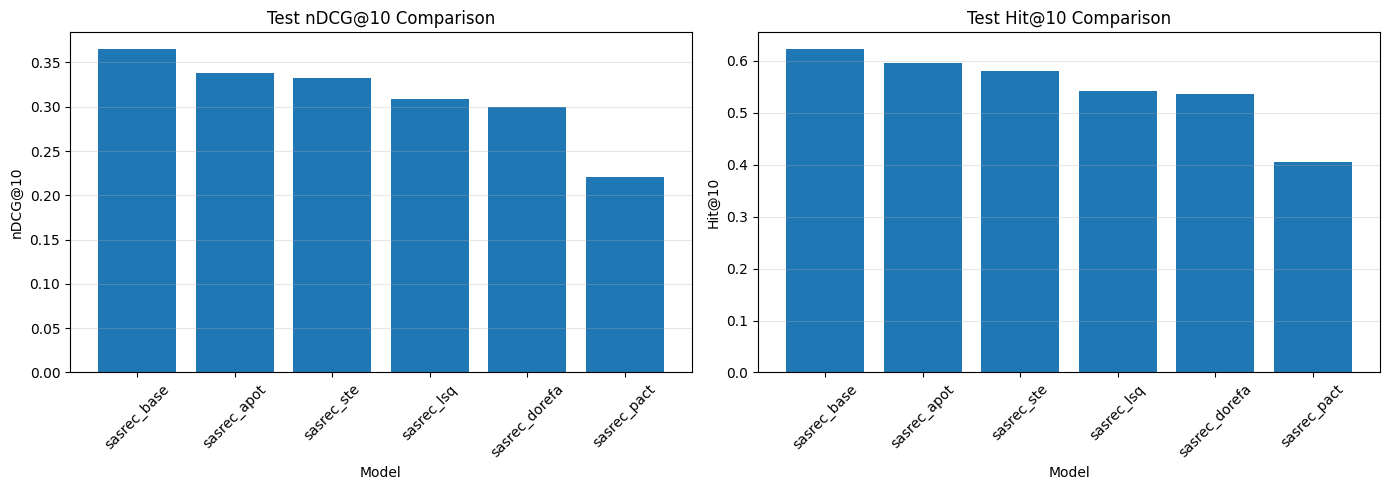

In [15]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(df_results['model_name'], df_results['test_ndcg'])
ax1.set_xlabel('Model')
ax1.set_ylabel(f'nDCG@{EVALUATE_K}')
ax1.set_title(f'Test nDCG@{EVALUATE_K} Comparison')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(df_results['model_name'], df_results['test_hit'])
ax2.set_xlabel('Model')
ax2.set_ylabel(f'Hit@{EVALUATE_K}')
ax2.set_title(f'Test Hit@{EVALUATE_K} Comparison')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Onnx INT8

In [18]:
!pip install onnxruntime -q

In [19]:
import torch
from sasrec.src.dataset import Dataset
from sasrec.src.model.sasrec_apot import QuantSASRecAPoT
from onnxruntime.quantization import quantize_dynamic, QuantType
import onnxruntime
import numpy as np
import time

In [20]:
from sasrec.src.dataset import Dataset


dataset = Dataset(
    batch_size=BATCH_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    data_filepath=data_filepath,
    debug=DEBUG,
)

test_loader = dataset.get_dataloader(data=dataset.user2items_test, split="test")

Getting train/valid/test splits: 100%|██████████| 6040/6040 [00:00<00:00, 86729.19it/s]


In [21]:
all_input_seqs = []
all_item_idxs = []
for batch in test_loader:
    inps, idxs = batch
    all_input_seqs.append(inps.cpu())
    all_item_idxs.append(idxs.cpu())

all_input_seqs = torch.cat(all_input_seqs, dim=0)
all_item_idxs = torch.cat(all_item_idxs, dim=0)
print(f"Shape: {all_input_seqs.shape}, {all_item_idxs.shape}")

Shape: torch.Size([6040, 50]), torch.Size([6040, 101])


In [22]:
ckpt_path = '/kaggle/working/outputs/sasrec_apot/best_checkpoint.pt'

model_fp32 = QuantSASRecAPoT(
    num_items=num_items,
    num_blocks=NUM_BLOCKS,
    hidden_dim=HIDDEN_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout_p=DROPOUT,
    share_item_emb=SHARE_ITEM_EMB,
    device="cpu",
    bits=BITS,
    k=APOT_K,
    init_alpha_act=APOT_INIT_ALPHA_ACT,
    use_weight_norm_w=APOT_USE_WEIGHT_NORM,
).cpu()
model_fp32.device = "cpu"

checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)
model_fp32.load_state_dict(checkpoint["best_model_state_dict"])
model_fp32.eval()

QuantSASRecAPoT(
  (embedding_layer): EmbeddingLayer(
    (item_emb_matrix): Embedding(3417, 50)
    (positional_emb): Embedding(50, 50)
  )
  (self_attn_blocks): ModuleList(
    (0-1): 2 x SelfAttnBlock(
      (layer_norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
      )
      (ffnn): PointWiseFFNN(
        (W1): Linear(in_features=50, out_features=50, bias=True)
        (W2): Linear(in_features=50, out_features=50, bias=True)
        (relu): ReLU()
      )
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  (apot_embed): APoTQuantRCF()
  (apot_attn_blocks): ModuleList(
    (0-1): 2 x APoTQuantRCF()
  )
  (apot_final): APoTQuantRCF()
)

In [23]:
import torch
import numpy as np
import onnx
from onnxruntime.quantization import quantize_static, CalibrationDataReader

In [24]:
class SASRecDataReader(CalibrationDataReader):
    def __init__(self, dataloader, num_batches=100):
        self.dataloader = dataloader
        self.num_batches = min(num_batches, len(dataloader))
        self.iterator = None
        self.batch_count = 0
    
    def get_next(self):
        if self.iterator is None:
            self.iterator = iter(self.dataloader)
            self.batch_count = 0
        
        if self.batch_count >= self.num_batches:
            return None
        
        try:
            input_seqs, item_idxs = next(self.iterator)
            self.batch_count += 1
            
            return {
                "input_seqs": input_seqs.cpu().numpy().astype(np.int64),
                "item_idxs": item_idxs.cpu().numpy().astype(np.int64)
            }
        except StopIteration:
            return None

In [25]:
sample_batch = next(iter(test_loader))
sample_seqs, sample_items = sample_batch
sample_seqs = sample_seqs.cpu()
sample_items = sample_items.cpu()

In [26]:
onnx_fp32 = "sasrec_fp32.onnx"
torch.onnx.export(
    model_fp32,
    (sample_seqs, sample_items),
    onnx_fp32,
    input_names=["input_seqs", "item_idxs"],
    output_names=["output"],
    opset_version=14,
    dynamic_axes={
        'input_seqs': {0: 'batch'},
        'item_idxs': {0: 'batch'},
        'output': {0: 'batch'}
    }
)
print(f"Exported FP32 ONNX: {onnx_fp32}")

Exported FP32 ONNX: sasrec_fp32.onnx


In [27]:
onnx_fp32_quantized = "sasrec_fp32_quantized_int8.onnx"
calibration_reader_fp32 = SASRecDataReader(test_loader, num_batches=100)

quantize_static(
    onnx_fp32,
    onnx_fp32_quantized,
    calibration_data_reader=calibration_reader_fp32
)
print(f"INT8 static quantization: {onnx_fp32_quantized}")

2025-11-17 14:11:36,201 | WARNING | root | Please consider to run pre-processing before quantization. Refer to example: https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/ReadMe.md 
2025-11-17 14:12:06,136 | WARNING | root | Please consider pre-processing before quantization. See https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/ReadMe.md 


INT8 static quantization: sasrec_fp32_quantized_int8.onnx


In [28]:
def compare_model_weights(model_path_1, model_path_2, model_name_1="Model 1", model_name_2="Model 2"):
    model1 = onnx.load(model_path_1)
    model2 = onnx.load(model_path_2)
    
    weights1 = {init.name: onnx.numpy_helper.to_array(init) for init in model1.graph.initializer}
    weights2 = {init.name: onnx.numpy_helper.to_array(init) for init in model2.graph.initializer}
    
    print(f"\n{'='*70}")
    print(f"  {model_name_1} vs {model_name_2}")
    print(f"{'='*70}")
    
    print(f"\nTensor counts:")
    print(f"  {model_name_1:20s}: {len(weights1):4d} tensors")
    print(f"  {model_name_2:20s}: {len(weights2):4d} tensors")
    
    common_weights = set(weights1.keys()) & set(weights2.keys())
    new_in_model2 = set(weights2.keys()) - set(weights1.keys())
    
    if new_in_model2:
        scale_tensors = [n for n in new_in_model2 if 'scale' in n.lower()]
        zp_tensors = [n for n in new_in_model2 if 'zero_point' in n.lower()]
        
        print(f"\nQuantization artifacts:")
        print(f"  New tensors          : {len(new_in_model2):4d}")
        print(f"  Scale parameters     : {len(scale_tensors):4d}")
        print(f"  Zero-point parameters: {len(zp_tensors):4d}")
    
    if len(common_weights) > 0:
        print(f"\nWeight comparison (sample of {min(5, len(common_weights))} common tensors):")
        print(f"{'':4s}{'Tensor Name':<45s} {'Shape':<15s} {'Changed':<10s} {'Diff %':<10s}")
        print(f"  {'-'*68}")
        
        for i, name in enumerate(list(common_weights)[:5]):
            w1 = weights1[name]
            w2 = weights2[name]
            
            are_different = not np.allclose(w1, w2, rtol=1e-5, atol=1e-5)
            diff_percentage = np.mean(np.abs(w1 - w2)) / (np.mean(np.abs(w1)) + 1e-8) * 100
            
            shape_str = str(w1.shape) if len(str(w1.shape)) < 15 else str(w1.shape)[:12] + "..."
            name_short = name if len(name) < 45 else "..." + name[-42:]
            
            print(f"  {i+1}. {name_short:<45s} {shape_str:<15s} {'Yes' if are_different else 'No':<10s} {diff_percentage:>6.2f}%")
    
    return weights1, weights2


def compare_models_summary(models_info):
    print(f"\n{'='*70}")
    print(f"  MODEL COMPARISON SUMMARY")
    print(f"{'='*70}")
    
    print(f"\n{'Model':<30s} {'Size (MB)':<12s} {'Compression':<12s} {'Status'}")
    print(f"{'-'*70}")
    
    sizes = {}
    for name, path in models_info.items():
        if os.path.exists(path):
            size_mb = os.path.getsize(path) / (1024 * 1024)
            sizes[name] = size_mb
    
    if "FP32 Original" in sizes:
        base_size = sizes["FP32 Original"]
        print(f"{'FP32 Original':<30s} {base_size:>8.2f}    {'1.00x':<12s} Baseline")
        
        if "FP32 Quantized" in sizes:
            quant_size = sizes["FP32 Quantized"]
            ratio = base_size / quant_size
            print(f"{'FP32 Quantized (INT8)':<30s} {quant_size:>8.2f}    {ratio:>4.2f}x{'':8s} Quantized")
    
    print(f"{'-'*70}")
    
    if "FP32 Original" in sizes and "FP32 Quantized" in sizes:
        saved_mb = sizes["FP32 Original"] - sizes["FP32 Quantized"]
        saved_pct = (saved_mb / sizes["FP32 Original"]) * 100
        print(f"\nSpace saved: {saved_mb:.2f} MB ({saved_pct:.1f}%)")



w_fp32, w_fp32_quant = compare_model_weights(
    onnx_fp32, 
    onnx_fp32_quantized,
    "FP32 Original",
    "FP32 Quantized (INT8)"
)

models_info = {
    "FP32 Original": onnx_fp32,
    "FP32 Quantized": onnx_fp32_quantized,
}

compare_models_summary(models_info)


  FP32 Original vs FP32 Quantized (INT8)

Tensor counts:
  FP32 Original       :   41 tensors
  FP32 Quantized (INT8):  481 tensors

Quantization artifacts:
  New tensors          :  473
  Scale parameters     :  220
  Zero-point parameters:  220

Weight comparison (sample of 5 common tensors):
    Tensor Name                                   Shape           Changed    Diff %    
  --------------------------------------------------------------------
  1. onnx::Expand_1912                             (1, 1, 1, 2)    No           0.00%
  2. onnx::Expand_1906                             (1, 1, 1, 2)    No           0.00%
  3. onnx::Expand_1918                             (1, 1, 1, 2)    No           0.00%
  4. onnx::Expand_1924                             (1, 1, 1, 2)    No           0.00%
  5. onnx::Expand_1900                             (1, 1, 1, 2)    No           0.00%

  MODEL COMPARISON SUMMARY

Model                          Size (MB)    Compression  Status
---------------------

In [29]:
def check_quantized_weights_detailed(model_path):
    import onnx
    import numpy as np
    
    print(f"\n{'='*70}")
    print(f"  Detailed Analysis: {model_path}")
    print(f"{'='*70}")
    
    model = onnx.load(model_path)
    weights = {init.name: onnx.numpy_helper.to_array(init) for init in model.graph.initializer}
    
    dtype_groups = {}
    for name, w in weights.items():
        dtype = str(w.dtype)
        if dtype not in dtype_groups:
            dtype_groups[dtype] = []
        dtype_groups[dtype].append((name, w))
    
    print("\nData type distribution:")
    for dtype, tensors in sorted(dtype_groups.items()):
        total_size = sum(w.nbytes for _, w in tensors)
        print(f"  {dtype:15s}: {len(tensors):4d} tensors, {total_size / 1024:>8.2f} KB")
        
        if 'int' in dtype.lower() or 'uint' in dtype.lower():
            print(f"    Quantized weights (examples):")
            for name, w in tensors[:3]:
                name_short = name if len(name) < 50 else "..." + name[-47:]
                print(f"      {name_short}")
                print(f"        Shape: {w.shape}, Range: [{w.min()}, {w.max()}]")
    
    print("\nQuantized layers (weight + scale + zero_point):")
    
    quantized_layers = {}
    for name in weights.keys():
        if '_quantized' in name or 'MatMul' in name or 'Gemm' in name:
            base_name = name.replace('_quantized', '').replace('_scale', '').replace('_zero_point', '')
            if base_name not in quantized_layers:
                quantized_layers[base_name] = {}
            
            if '_scale' in name or 'scale' in name.lower():
                quantized_layers[base_name]['scale'] = weights[name]
            elif '_zero_point' in name or 'zero_point' in name.lower() or 'zp' in name.lower():
                quantized_layers[base_name]['zero_point'] = weights[name]
            else:
                quantized_layers[base_name]['weight'] = weights[name]
    
    count = 0
    for layer_name, params in quantized_layers.items():
        if 'weight' in params and 'scale' in params:
            count += 1
            if count <= 5:
                w = params['weight']
                s = params['scale']
                zp = params.get('zero_point', None)
                
                name_short = layer_name if len(layer_name) < 50 else "..." + layer_name[-47:]
                print(f"\n  [{count}] {name_short}")
                print(f"      Weight: dtype={w.dtype}, shape={w.shape}, range=[{w.min()}, {w.max()}]")
                print(f"      Scale: {s.flatten()[0] if s.size > 0 else 'N/A':.6f}")
                if zp is not None:
                    print(f"      Zero point: {zp.flatten()[0] if zp.size > 0 else 'N/A'}")
    
    if count > 5:
        print(f"\n  ... and {count - 5} more quantized layers")
    
    print(f"\nTotal quantized layers found: {count}")


check_quantized_weights_detailed("sasrec_fp32_quantized_int8.onnx")


  Detailed Analysis: sasrec_fp32_quantized_int8.onnx

Data type distribution:
  float32        :  228 tensors,     0.92 KB
  int32          :    4 tensors,     0.40 KB
    Quantized weights (examples):
      ...attn_blocks.0.self_attn.out_proj.bias_quantized
        Shape: (50,), Range: [-3971, 2051]
      ....0.self_attn.out_proj.bias_quantized_zero_point
        Shape: (), Range: [0, 0]
      ...attn_blocks.1.self_attn.out_proj.bias_quantized
        Shape: (50,), Range: [-657, 477]
  int8           :  249 tensors,   199.58 KB
    Quantized weights (examples):
      embedding_layer.item_emb_matrix.weight_zero_point
        Shape: (), Range: [-7, -7]
      embedding_layer.item_emb_matrix.weight_quantized
        Shape: (3417, 50), Range: [-128, 127]
      /embedding_layer/Constant_output_0_zero_point
        Shape: (), Range: [-128, -128]

Quantized layers (weight + scale + zero_point):

  [1] onnx::MatMul_1949
      Weight: dtype=int8, shape=(50, 50), range=[-118, 127]
      Scale: 

In [32]:
import onnxruntime
import numpy as np
import time
from tqdm import tqdm

batch_size = 256

results = {}

for model_path, label in [(onnx_fp32, "FP32"), (onnx_fp32_quantized, "INT8")]:
    sess = onnxruntime.InferenceSession(model_path, providers=['CPUExecutionProvider'])
    input_names = [i.name for i in sess.get_inputs()]
    
    logits_list = []
    times = []
    
    num_samples = all_input_seqs.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    for batch_start in tqdm(range(0, num_samples, batch_size), total=num_batches, desc=f"{label} inference"):
        batch_seqs = all_input_seqs[batch_start:batch_start + batch_size].numpy()
        batch_items = all_item_idxs[batch_start:batch_start + batch_size].numpy()
        
        inputs = {
            input_names[0]: batch_seqs,
            input_names[1]: batch_items
        }
        
        start = time.time()
        output = sess.run(None, inputs)
        times.append(time.time() - start)
        
        logits = output[0]
        logits_list.append(logits)
    
    all_logits = np.concatenate(logits_list, axis=0)
    mean_latency = np.mean(times) * 1000
    std_latency = np.std(times) * 1000
    total_time = np.sum(times)
    throughput = num_samples / total_time
    
    results[label] = {
        'mean_latency': mean_latency,
        'std_latency': std_latency,
        'total_time': total_time,
        'throughput': throughput,
        'samples': all_logits.shape[0]
    }
    
    print(f"{label:6s}: Mean latency = {mean_latency:6.2f} ms/batch (±{std_latency:.2f}); "
          f"Throughput = {throughput:6.2f} samples/s; Total samples: {all_logits.shape[0]}")

print(f"\n{'='*70}")
print(f"  PERFORMANCE COMPARISON")
print(f"{'='*70}")

if "FP32" in results and "INT8" in results:
    fp32 = results["FP32"]
    int8 = results["INT8"]
    
    speedup = fp32['mean_latency'] / int8['mean_latency']
    throughput_improvement = int8['throughput'] / fp32['throughput']
    
    print(f"\n{'Metric':<25s} {'FP32':<20s} {'INT8':<20s} {'Improvement'}")
    print(f"{'-'*70}")
    print(f"{'Mean latency (ms/batch)':<25s} {fp32['mean_latency']:>8.2f} (±{fp32['std_latency']:.2f}){'':10s} "
          f"{int8['mean_latency']:>8.2f} (±{int8['std_latency']:.2f}){'':10s} {speedup:>4.2f}x")
    print(f"{'Throughput (samples/s)':<25s} {fp32['throughput']:>18.2f}{'':10s} "
          f"{int8['throughput']:>18.2f}{'':10s} {throughput_improvement:>4.2f}x")
    print(f"{'Total time (s)':<25s} {fp32['total_time']:>18.2f}{'':10s} "
          f"{int8['total_time']:>18.2f}{'':10s} {fp32['total_time']/int8['total_time']:>4.2f}x")
    
    print(f"\n{'='*70}")
    if speedup > 1.0:
        print(f"INT8 is {speedup:.2f}x faster than FP32")
    elif speedup < 1.0:
        print(f"INT8 is {1/speedup:.2f}x slower than FP32 (may need optimization)")
    else:
        print(f"INT8 and FP32 have similar performance")

FP32 inference: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


FP32  : Mean latency = 970.13 ms/batch (±91.14); Throughput = 259.42 samples/s; Total samples: 6040


INT8 inference: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]

INT8  : Mean latency = 1047.40 ms/batch (±86.33); Throughput = 240.28 samples/s; Total samples: 6040

  PERFORMANCE COMPARISON

Metric                    FP32                 INT8                 Improvement
----------------------------------------------------------------------
Mean latency (ms/batch)     970.13 (±91.14)            1047.40 (±86.33)           0.93x
Throughput (samples/s)                259.42                       240.28           0.93x
Total time (s)                         23.28                        25.14           0.93x

INT8 is 1.08x slower than FP32 (may need optimization)


In [31]:
import zipfile
import os
from pathlib import Path

def create_zip_archive(source_dir, output_path):
    """Создает ZIP архив из папки"""
    source_path = Path(source_dir)
    
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(source_path):
            for file in files:
                file_path = Path(root) / file
                arcname = file_path.relative_to(source_path.parent)
                zipf.write(file_path, arcname)
                print(f"Added: {arcname}")
    
    size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"\nArchive created: {output_path}")
    print(f"Size: {size_mb:.2f} MB")


create_zip_archive('/kaggle/working/outputs', '/kaggle/working/outputs.zip')

Added: outputs/sasrec_ste/best_checkpoint.pt
Added: outputs/sasrec_ste/most_recent_checkpoint.pt
Added: outputs/sasrec_apot/best_checkpoint.pt
Added: outputs/sasrec_apot/most_recent_checkpoint.pt
Added: outputs/sasrec_pact/best_checkpoint.pt
Added: outputs/sasrec_pact/most_recent_checkpoint.pt
Added: outputs/sasrec_base/best_checkpoint.pt
Added: outputs/sasrec_base/most_recent_checkpoint.pt
Added: outputs/sasrec_lsq/best_checkpoint.pt
Added: outputs/sasrec_lsq/most_recent_checkpoint.pt
Added: outputs/sasrec_dorefa/best_checkpoint.pt
Added: outputs/sasrec_dorefa/most_recent_checkpoint.pt

Archive created: /kaggle/working/outputs.zip
Size: 25.87 MB
